# Recurrent Neural Networks
1. Build RNN to predict time-series data.
2. Build LSTM to predict time-series data. (Assignment)

## Import dependencies

In [5]:
import torch 
import torch.nn as nn

import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab\ Notebooks/

In [1]:
!pwd

/content


In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('{name} Uploaded.'.format(name=fn))

Saving aapl.us.txt to aapl.us.txt
Saving goog.us.txt to goog.us.txt
Saving ibm.us.txt to ibm.us.txt
aapl.us.txt Uploaded.
goog.us.txt Uploaded.
ibm.us.txt Uploaded.


In [97]:
def stocks_data(symbols, dates):
    df = pd.DataFrame(index=dates)
    for symbol in symbols:
        # df_temp = pd.read_csv("./data/{}.us.txt".format(symbol), index_col='Date',
        df_temp = pd.read_csv("./{}.us.txt".format(symbol), index_col='Date',
                parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
    return df

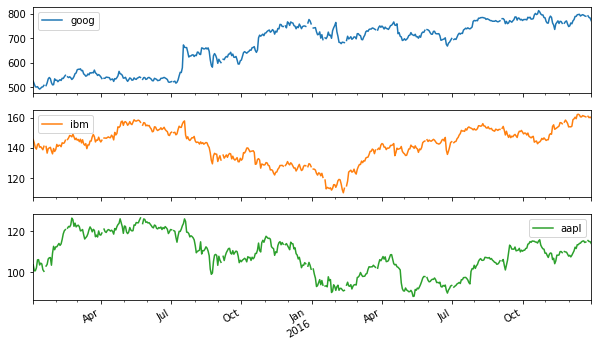

In [98]:
dates = pd.date_range('2015-01-02','2016-12-31',freq='B')
symbols = ['goog','ibm','aapl']
df = stocks_data(symbols, dates)
df.fillna(method='pad')
df.plot(figsize=(10, 6), subplots=True);

In [99]:
df.head()

,goog,ibm,aapl
2015-01-02,524.81,145.54,103.50
2015-01-05,513.87,143.24,100.58
2015-01-06,501.96,140.14,100.59
2015-01-07,501.10,139.23,102.01
2015-01-08,502.68,142.26,105.93


In [100]:
dates = pd.date_range('2010-01-02','2017-10-11',freq='B')

# TODO: Load just IBM "Close" data to dataframe
df1 = pd.DataFrame(index=dates)
df_ibm = pd.read_csv('./ibm.us.txt', parse_dates=True, index_col=0)
df_ibm = df1.join(df_ibm)


Text(0.5, 1.0, 'IBM stock')

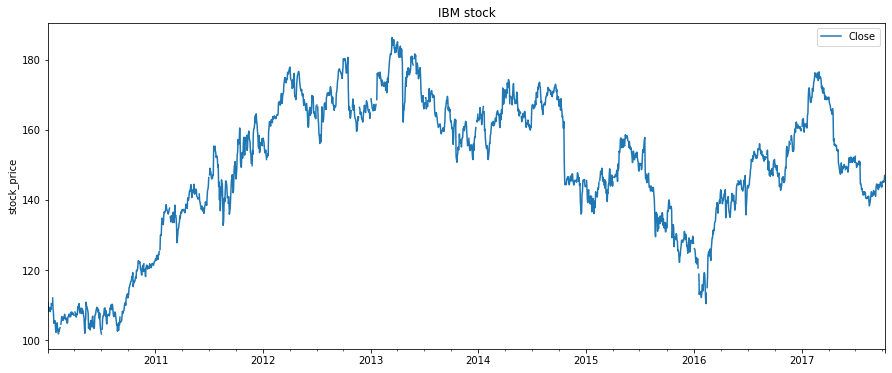

In [101]:
df_ibm[['Close']].plot(figsize=(15,6))
plt.ylabel('stock_price')
plt.title('IBM stock')

In [102]:
df_ibm = df_ibm[['Close']]
df_ibm

,Close
2010-01-04,110.59
2010-01-05,109.26
2010-01-06,108.56
2010-01-07,108.19
2010-01-08,109.26
...,...
2017-10-05,145.27
2017-10-06,145.03
2017-10-09,145.93
2017-10-10,147.03


In [103]:
df_ibm['Close'].values.reshape(-1,1)

array([[110.59],
       [109.26],
       [108.56],
       ...,
       [145.93],
       [147.03],
       [146.16]])

In [104]:
df_ibm = df_ibm.fillna(method='ffill')

# TODO: Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
df_ibm['Close'] = scaler.fit_transform(df_ibm['Close'].values.reshape(-1, 1))

In [105]:
df_ibm

,Close
2010-01-04,-0.790830
2010-01-05,-0.822264
2010-01-06,-0.838809
2010-01-07,-0.847554
2010-01-08,-0.822264
...,...
2017-10-05,0.028835
2017-10-06,0.023162
2017-10-09,0.044434
2017-10-10,0.070433


In [106]:
# TODO: Prepare & split data for training & testing
def load_data(stock, look_back):
    data_raw = stock.values
    data = []

    for idx in range(len(data_raw)-look_back):
      data.append(data_raw[idx:idx+look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]

    return x_train, y_train, x_test, y_test

look_back = 60 # choose sequence length
x_train, y_train, x_test, y_test = load_data(df_ibm, look_back)
print('x_train.shape =', x_train.shape)
print('y_train.shape =', y_train.shape)
print('x_test.shape =', x_test.shape)
print('y_test.shape =', y_test.shape)

x_train.shape = (1574, 59, 1)
y_train.shape = (1574, 1)
x_test.shape = (394, 59, 1)
y_test.shape = (394, 1)


In [107]:
# make training and test sets in torch
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

## Create an RNN model

In [124]:
# MODEL HYPERPARAMETERS
input_dim = 1
hidden_dim = 64 #32
num_layers = 2  # 3
output_dim = 1

In [125]:

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
      super(RNNModel, self).__init__()
      self.hidden_dim = hidden_dim
      self.num_layers = num_layers
      self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
      out, hn = self.rnn(x, h0.detach())
      out = self.fc(out[:,-1, :])
      return out

In [126]:
# Build LSTM (Assignment)
#####################
class LSTMModel(nn.Module):
  def __init__(self,input_dim, hidden_dim, num_layers, output_dim):
      super(LSTMModel, self).__init__()
      self.hidden_dim = hidden_dim
      self.num_layers = num_layers
      self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
      self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_() # 처음에는 gradient가 필요하다 하는 것
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
    out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
    out = self.fc(out[:,-1, :]) # 마지막번째의 value가 우리의 output이 될 것 
    return out

In [127]:
# model = RNNModel(input_dim, hidden_dim, num_layers, output_dim)
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model

LSTMModel(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [128]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

## Train

In [129]:
# TRAIN PARAMETERS
num_epochs = 100

In [130]:
train_losses = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    
    # epoch 10단위로 기록하게 하자
    if t % 10 == 0 and t != 0:
      print("Epoch ", t, "MSE: ", loss.item())
    train_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch  10 MSE:  0.16074715554714203
Epoch  20 MSE:  0.02004980854690075
Epoch  30 MSE:  0.0128275565803051
Epoch  40 MSE:  0.006615179590880871
Epoch  50 MSE:  0.005385114811360836
Epoch  60 MSE:  0.004389507696032524
Epoch  70 MSE:  0.003976213745772839
Epoch  80 MSE:  0.003805069252848625
Epoch  90 MSE:  0.0036746570840477943


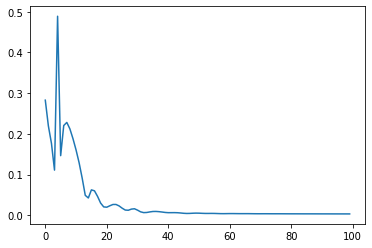

In [132]:
plt.plot(train_losses)

## Predict

In [133]:
# make predictions
y_test_pred = model(x_test)
y_test_pred.shape

torch.Size([394, 1])

In [134]:
y_train_pred_prices = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train_prices = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred_prices = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test_prices = scaler.inverse_transform(y_test.detach().numpy())

train_error = math.sqrt(mean_squared_error(y_train_prices[:,0], y_train_pred_prices[:,0]))
test_error = math.sqrt(mean_squared_error(y_test_prices[:,0], y_test_pred_prices[:,0]))
print(train_error)
print(test_error)

2.5256895049235095
1.9523746727688471


In [135]:
df_ibm.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2017-09-28', '2017-09-29', '2017-10-02', '2017-10-03',
               '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-09',
               '2017-10-10', '2017-10-11'],
              dtype='datetime64[ns]', length=2028, freq='B')

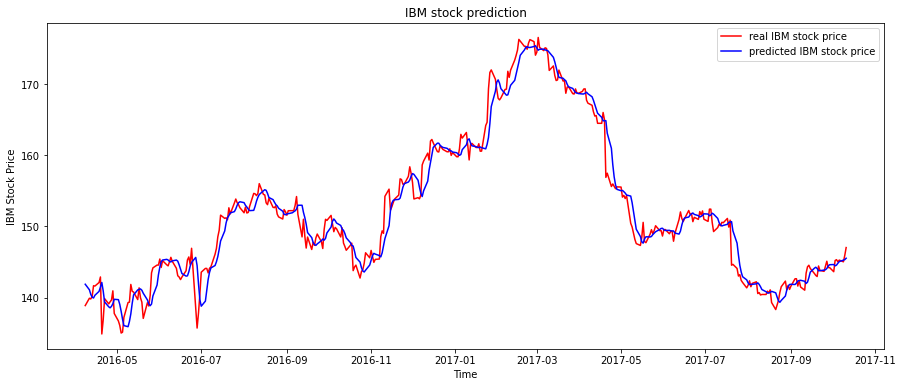

In [136]:
fig = plt.figure(figsize=(15,6))

plt.plot(df_ibm[len(df_ibm)-len(y_test_prices):].index, y_test_prices, color='red', label="real IBM stock price")
plt.plot(df_ibm[len(df_ibm)-len(y_test_pred_prices):].index, y_test_pred_prices, color='blue', label="predicted IBM stock price")
plt.title("IBM stock prediction")
plt.xlabel("Time")
plt.ylabel("IBM Stock Price")
plt.legend()
plt.savefig("IBM_predictions.png")

In [137]:
company='케이존'
name='천재홍'

print(f'{company}의 {name} 개발자 8회차 강의에 대한 과제 이행 후 제출합니다. 감사합니다.')

케이존의 천재홍 개발자 8회차 강의에 대한 과제 이행 후 제출합니다. 감사합니다.
